In [1]:
# Importing modules
import pandas as pd

# Read datasets/papers.csv into papers
papers = pd.read_csv("papers.csv")

# Print out the first rows of papers
papers.head()

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


In [2]:
# Remove the columns
papers.drop(['id', 'event_type', 'pdf_name'], axis=1, inplace=True)

# Print out the first rows of papers
papers.head()

,year,title,abstract,paper_text
0,1987,Self-Organization of Associative Database and ...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,1987,A Mean Field Theory of Layer IV of Visual Cort...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,1988,Storing Covariance by the Associative Long-Ter...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1994,Bayesian Query Construction for Neural Network...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1994,"Neural Network Ensembles, Cross Validation, an...",Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


In [3]:
# Load the regular expression library
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
##Creating a list of custom stopwords
new_words = ["fig","figure","image","sample","using", 
             "show", "result", "large", 
             "also", "one", "two", "three", 
             "four", "five", "seven","eight","nine"]
stop_words = list(stop_words.union(new_words))

def pre_process(text):
    
    # lowercase
    text=text.lower()
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    ##Convert to list from string
    text = text.split()
    
    # remove stopwords
    text = [word for word in text if word not in stop_words]

    # remove words less than three letters
    text = [word for word in text if len(word) >= 3]

    # lemmatize
    lmtzr = WordNetLemmatizer()
    text = [lmtzr.lemmatize(word) for word in text]
    
    return ' '.join(text)

# Print the titles of the first rows 
print(papers['title'].head())

# The following line 
papers['title_processed'] = papers['title'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
papers['title_processed'] = papers['title_processed'].map(lambda x: x.lower())

# Print the processed titles of the first rows 
papers['title_processed'].head()



0    Self-Organization of Associative Database and ...
1    A Mean Field Theory of Layer IV of Visual Cort...
2    Storing Covariance by the Associative Long-Ter...
3    Bayesian Query Construction for Neural Network...
4    Neural Network Ensembles, Cross Validation, an...
Name: title, dtype: object


0    self-organization of associative database and ...
1    a mean field theory of layer iv of visual cort...
2    storing covariance by the associative long-ter...
3    bayesian query construction for neural network...
4    neural network ensembles cross validation and ...
Name: title_processed, dtype: object

In [13]:
print(papers.year.min())
print(papers.year.max())

1987
2017


In [16]:
papers = papers.sort_values(by=['year'])

True

In [4]:
# %%time
# docs = papers['paper_text'].apply(lambda x:pre_process(x))

CPU times: total: 3min 11s
Wall time: 3min 16s


In [55]:
import pke
import string
idx = 5

def extract_keyword_from_text(text, n=10):
    # define the set of valid Part-of-Speeches
    pos = {'NOUN', 'PROPN', 'ADJ'}

    # 1. create a SingleRank extractor.
    extractor = pke.unsupervised.TopicRank()

    # 2. load the content of the document.
    stoplist = list(string.punctuation)
    stoplist += ['-lrb-', '-rrb-', '-lcb-', '-rcb-', '-lsb-', '-rsb-']
    stoplist += stopwords.words('english')
    extractor.load_document(input=text,
                            language='en',
                            stoplist=stoplist,
                            normalization=None)

    # 3. select the longest sequences of nouns and adjectives, that do
    #    not contain punctuation marks or stopwords as candidates.
    extractor.candidate_selection(pos=pos)


    # 4. weight the candidates using the sum of their word's scores that are
    #    computed using random walk. In the graph, nodes are words of
    #    certain part-of-speech (nouns and adjectives) that are connected if
    #    they occur in a window of 10 words.
    extractor.candidate_weighting(threshold=0.74, method='average')

    # 5. get the 10-highest scored candidates as keyphrases
    temp = extractor.get_n_best(n=n)
    return [w for w,_ in temp]


# now print the results
print("\n=====Title=====")
print(papers['title'][idx])
print("\n=====Abstract=====")
print(papers['abstract'][idx])
print("\n===Keywords===")
keyphrases = extract_keyword_from_text(papers['paper_text'][idx])
for k in keyphrases:
    print(k)


=====Title=====
Using a neural net to instantiate a deformable model

=====Abstract=====
Abstract Missing

===Keywords===
model
image
data
instantiation parameters
neural network
models
prediction network architecture
white space
search procedure
deformable model


In [57]:
from collections import Counter
from tqdm import tqdm
import numpy as np

periods = [1987+i*5 for i in range(6)]
N = 500
counters = []
for period in periods:
    papers_period = papers[(papers['year'] >= period) & (papers['year'] < period+5)]
    period_counter = Counter()
    num_papers_per_period = min(len(papers_period), N)
    iterates_period = np.random.permutation(num_papers_per_period)
    for i in tqdm(iterates_period):
        period_counter = period_counter + Counter(extract_keyword_from_text(papers_period.iloc[i].paper_text))
    counters.append(period_counter)

  3%|▎         | 13/500 [00:30<19:14,  2.37s/it]


KeyboardInterrupt: 

In [42]:
import pickle as pkl
with open("counter.pkl", 'wb') as f:
    pkl.dump(counters, f)

In [3]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from operator import itemgetter
import pickle as pkl

with open("counter.pkl", 'rb') as f:
    counters = pkl.load(f)



dict_values([125, 119, 56, 55, 53, 52, 45, 42, 39, 38])
dict_keys(['figure', 'network', 'units', 'input', 'number', 'model', 'weights', 'neural networks', 'networks', 'time'])


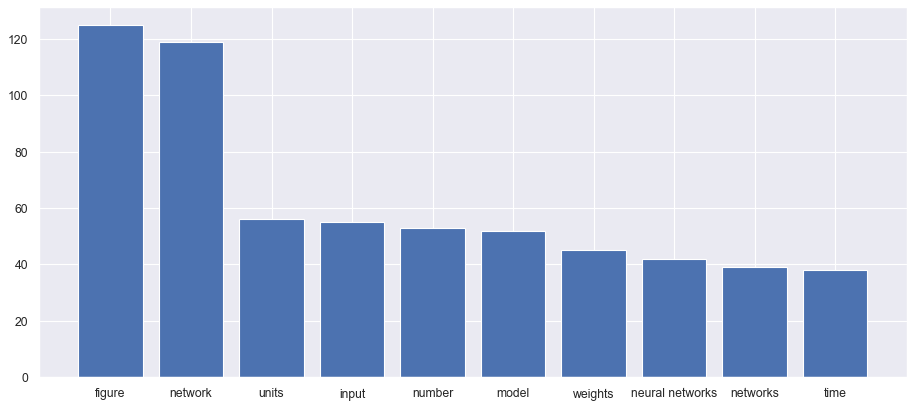

In [110]:
figure(figsize=(14, 6), dpi=80)

top_10_keywords = dict(sorted(counters[0].items(), key = itemgetter(1), reverse=True)[0:10])
print(top_10_keywords.values())
print(top_10_keywords.keys())
plt.bar(top_10_keywords.keys(), top_10_keywords.values())
plt.show()

dict_values([13, 13, 13, 13, 12, 12, 12, 12, 11, 11])
dict_keys(['functions', 'example', 'features', 'experts', 'images', 'cells', 'patterns', 'dynamics', 'class', 'approximation'])


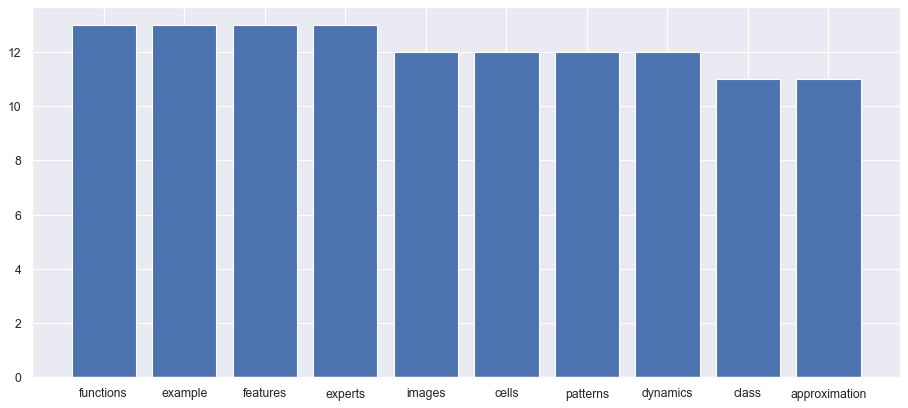

In [91]:
figure(figsize=(14, 6), dpi=80)

top_10_keywords = dict(sorted(counters[1].items(), key = itemgetter(1), reverse=True)[40:50])
print(top_10_keywords.values())
print(top_10_keywords.keys())
plt.bar(top_10_keywords.keys(), top_10_keywords.values())
plt.show()

dict_values([116, 103, 82, 61, 38, 38, 34, 31, 31])
dict_keys(['model', 'data', 'algorithm', 'number', 'set', 'time', 'network', 'neurons', 'input'])


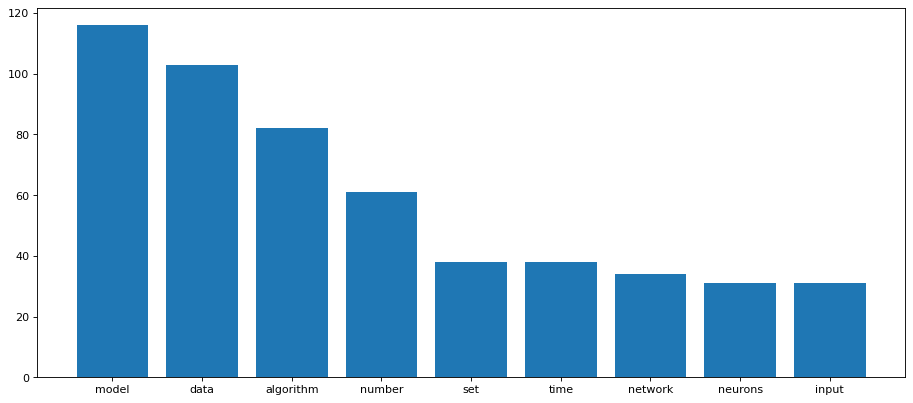

In [16]:
figure(figsize=(14, 6), dpi=80)

top_10_keywords = dict(sorted(counters[2].items(), key = itemgetter(1), reverse=True)[1:10])
print(top_10_keywords.values())
print(top_10_keywords.keys())
plt.bar(top_10_keywords.keys(), top_10_keywords.values())
plt.show()

dict_values([147, 146, 137, 115, 58, 56, 50, 47, 45])
dict_keys(['data', 'model', 'algorithm', 'number', 'set', 'problem', 'features', 'time', 'method'])


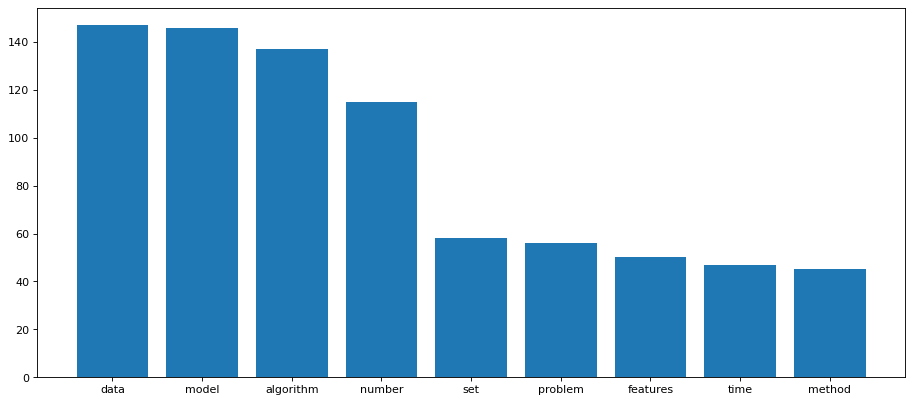

In [17]:
figure(figsize=(14, 6), dpi=80)

top_10_keywords = dict(sorted(counters[3].items(), key = itemgetter(1), reverse=True)[1:10])
print(top_10_keywords.values())
print(top_10_keywords.keys())
plt.bar(top_10_keywords.keys(), top_10_keywords.values())
plt.show()

dict_values([195, 192, 153, 150, 87, 78, 76, 70, 65])
dict_keys(['model', 'data', 'figure', 'number', 'problem', 'method', 'set', 'theorem', 'time'])


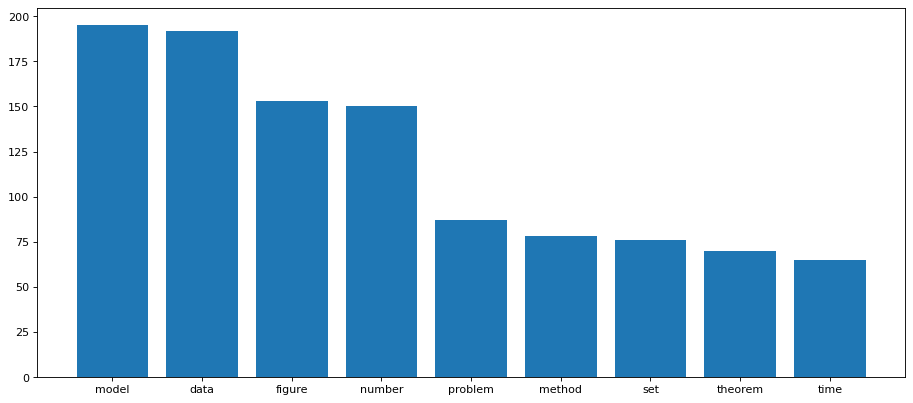

In [18]:
figure(figsize=(14, 6), dpi=80)

top_10_keywords = dict(sorted(counters[4].items(), key = itemgetter(1), reverse=True)[1:10])
print(top_10_keywords.values())
print(top_10_keywords.keys())
plt.bar(top_10_keywords.keys(), top_10_keywords.values())
plt.show()

dict_values([418, 261, 239, 228, 168, 144, 142, 126, 114, 88])
dict_keys(['algorithm', 'model', 'data', 'number', 'figure', 'theorem', 'problem', 'time', 'method', 'algorithms'])


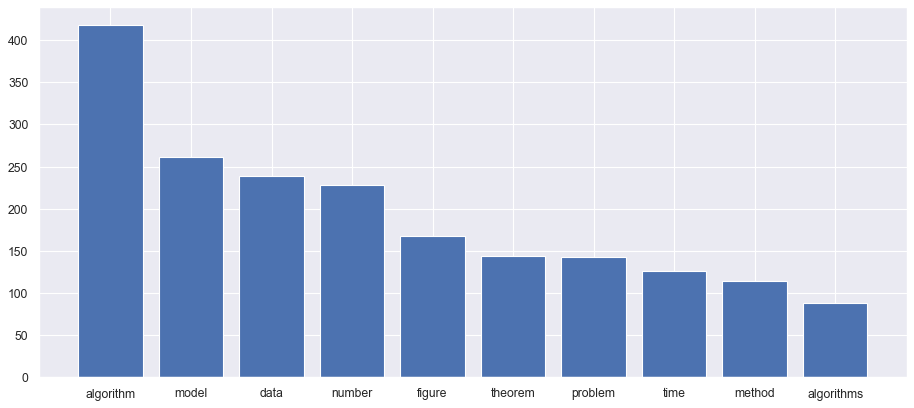

In [96]:
figure(figsize=(14, 6), dpi=80)

top_10_keywords = dict(sorted(counters[5].items(), key = itemgetter(1), reverse=True)[:10])
print(top_10_keywords.values())
print(top_10_keywords.keys())
plt.bar(top_10_keywords.keys(), top_10_keywords.values())
plt.show()

dict_values([10, 10, 10, 10, 9, 9, 9, 9, 9, 8])
dict_keys(['models', 'speech recognition', 'weight', 'activity', 'dynamics', 'images', 'features', 'parameters', 'probability', 'method'])


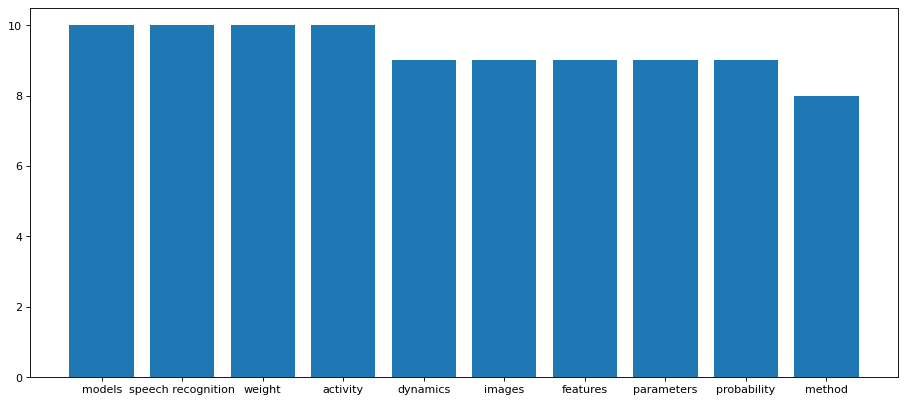

In [25]:
figure(figsize=(14, 6), dpi=80)

top_10_keywords = dict(sorted(counters[0].items(), key = itemgetter(1), reverse=True)[50:60])
print(top_10_keywords.values())
print(top_10_keywords.keys())
plt.bar(top_10_keywords.keys(), top_10_keywords.values())
plt.show()

dict_values([11, 11, 11, 11, 11, 10, 10, 10, 10, 10])
dict_keys(['classification', 'convergence', 'variance', 'distribution', 'experiments', 'chip', 'algorithms', 'nodes', 'point', 'sequence'])


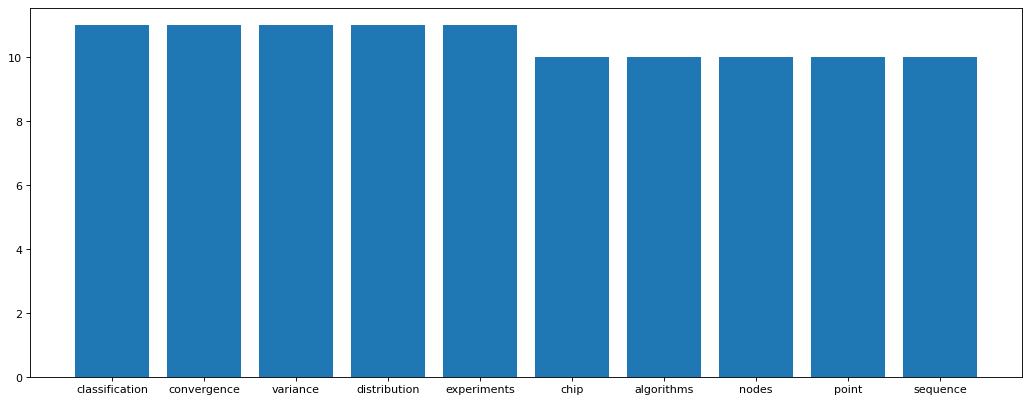

In [28]:
figure(figsize=(16, 6), dpi=80)

top_10_keywords = dict(sorted(counters[1].items(), key = itemgetter(1), reverse=True)[50:60])
print(top_10_keywords.values())
print(top_10_keywords.keys())
plt.bar(top_10_keywords.keys(), top_10_keywords.values())
plt.show()

dict_values([143, 116, 103, 82, 61, 38, 38, 34, 31, 31])
dict_keys(['figure', 'model', 'data', 'algorithm', 'number', 'set', 'time', 'network', 'neurons', 'input'])


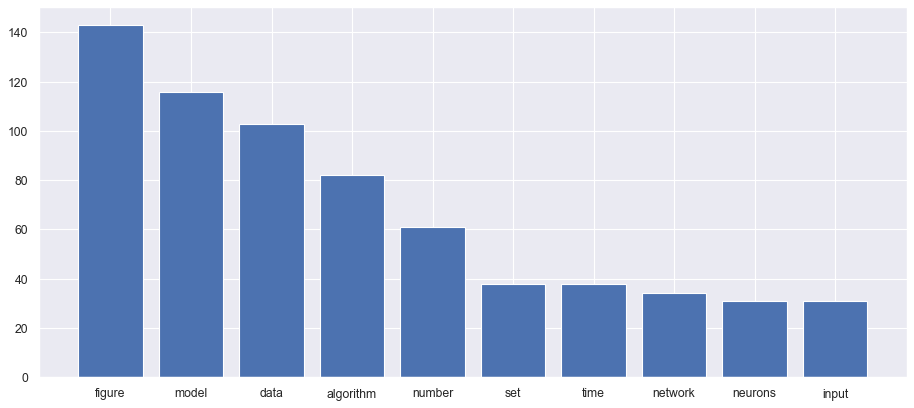

In [108]:
figure(figsize=(14, 6), dpi=80)

top_10_keywords = dict(sorted(counters[2].items(), key = itemgetter(1), reverse=True)[:10])
print(top_10_keywords.values())
print(top_10_keywords.keys())
plt.bar(top_10_keywords.keys(), top_10_keywords.values())
plt.show()

dict_values([44, 43, 40, 38, 30, 30, 30, 30, 29, 29])
dict_keys(['images', 'points', 'neurons', 'image', 'graph', 'section', 'distribution', 'parameters', 'theorem', 'algorithms'])


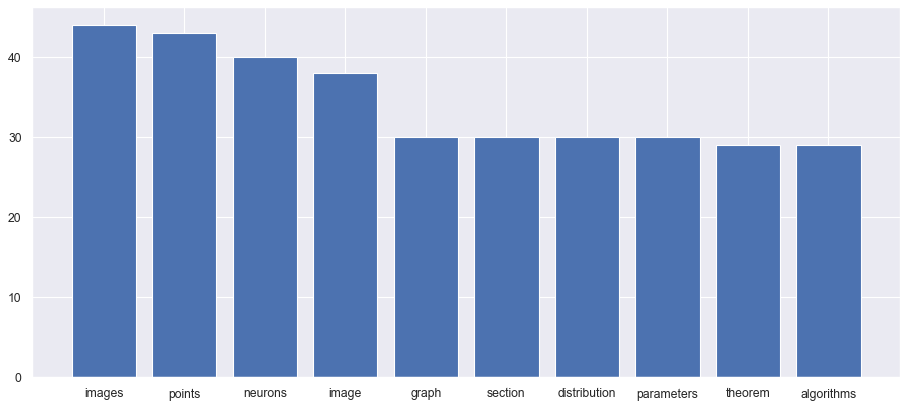

In [105]:
figure(figsize=(14, 6), dpi=80)

top_10_keywords = dict(sorted(counters[3].items(), key = itemgetter(1), reverse=True)[10:20])
print(top_10_keywords.values())
print(top_10_keywords.keys())
plt.bar(top_10_keywords.keys(), top_10_keywords.values())
plt.show()

dict_values([63, 54, 52, 48, 47, 44, 44, 41, 40, 39])
dict_keys(['features', 'images', 'models', 'image', 'variables', 'parameters', 'section', 'distribution', 'algorithms', 'function'])


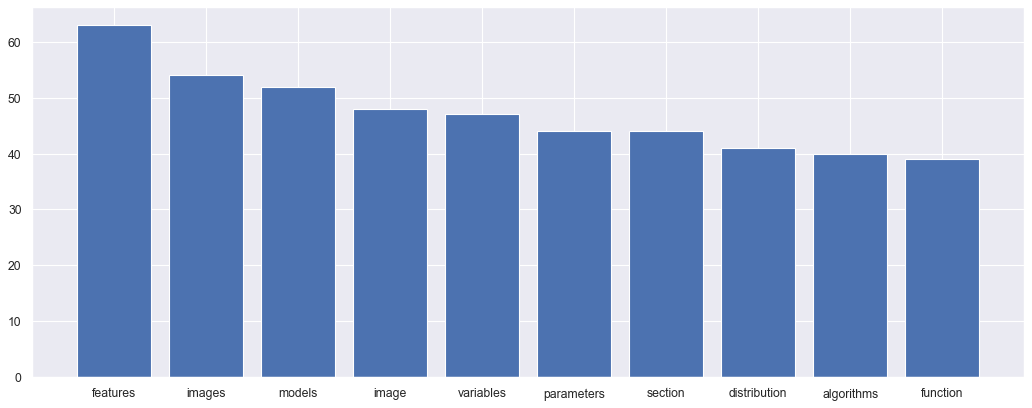

In [100]:
figure(figsize=(16, 6), dpi=80)

top_10_keywords = dict(sorted(counters[4].items(), key = itemgetter(1), reverse=True)[10:20])
print(top_10_keywords.values())
print(top_10_keywords.keys())
plt.bar(top_10_keywords.keys(), top_10_keywords.values())
plt.show()

dict_values([418, 261, 239, 228, 168, 144, 142, 126, 114, 88])
dict_keys(['algorithm', 'model', 'data', 'number', 'figure', 'theorem', 'problem', 'time', 'method', 'algorithms'])


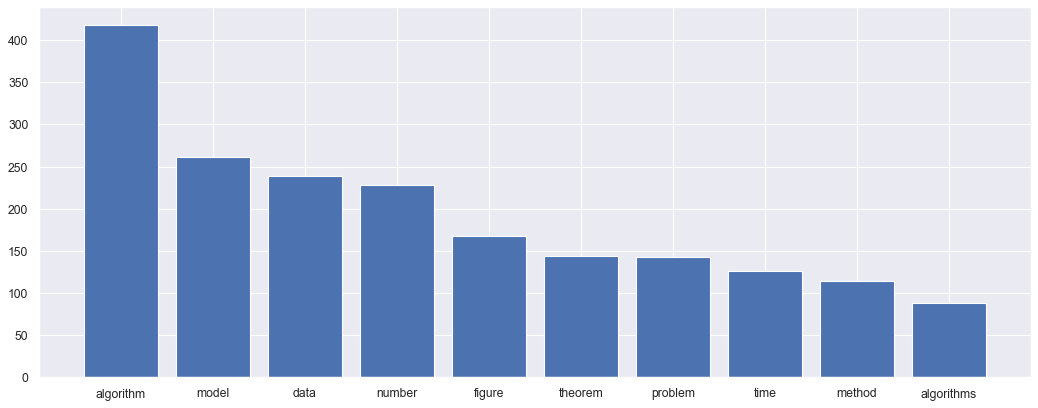

In [107]:
figure(figsize=(16, 6), dpi=80)

top_10_keywords = dict(sorted(counters[5].items(), key = itemgetter(1), reverse=True)[0:10])
print(top_10_keywords.values())
print(top_10_keywords.keys())
plt.bar(top_10_keywords.keys(), top_10_keywords.values())
plt.show()

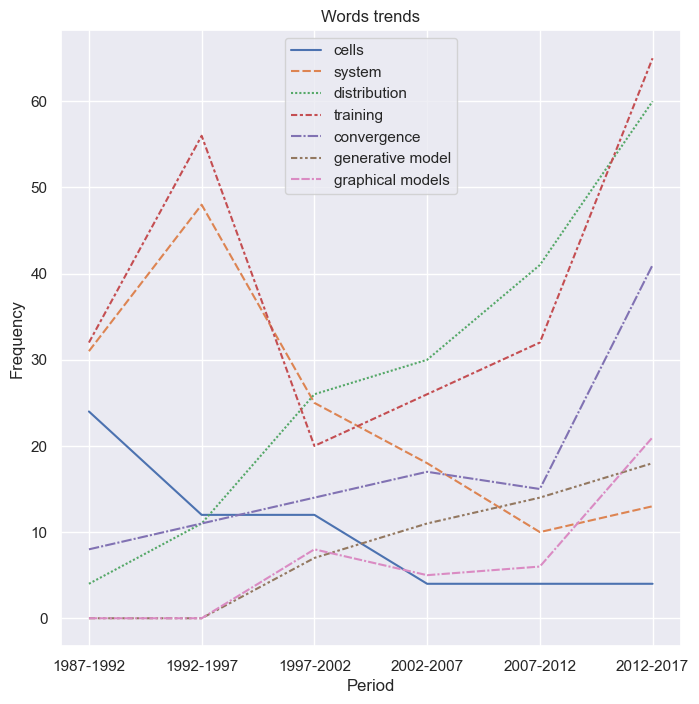

In [5]:
import seaborn as sns
import numpy as np
import pandas as pd

sns.set(rc={'figure.figsize':(8,8)})

x = ["1987-1992", "1992-1997", "1997-2002", "2002-2007", "2007-2012", "2012-2017"]
keywords = ["cells", "system", "distribution", "training", "convergence", "generative model", "graphical models"]
y = np.zeros((len(keywords), 6))
for i in range(6):
    for j, k in enumerate(keywords):
        y[j][i] = counters[i][k]

trends = pd.DataFrame()
trends.index = x
for i, k in enumerate(keywords):
    trends[k] = y[i]
plot = sns.lineplot(data=trends)
plot.set(title="Words trends", xlabel="Period", ylabel="Frequency")
fig = plot.get_figure()
fig.savefig("wt1.pdf")

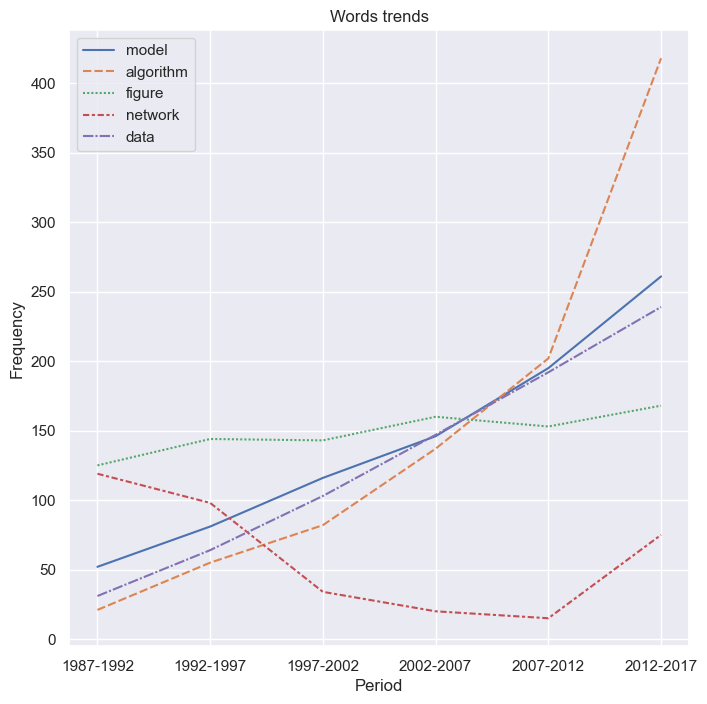

In [7]:
x = ["1987-1992", "1992-1997", "1997-2002", "2002-2007", "2007-2012", "2012-2017"]
keywords = ["model", "algorithm", "figure", "network", "data"]
y = np.zeros((len(keywords), 6))
for i in range(6):
    for j, k in enumerate(keywords):
        y[j][i] = counters[i][k]

trends = pd.DataFrame()
trends.index = x
for i, k in enumerate(keywords):
    trends[k] = y[i]
plot = sns.lineplot(data=trends)
plot.set(title="Words trends", xlabel="Period", ylabel="Frequency")
fig = plot.get_figure()
fig.savefig("wt2.pdf")

period
1987-1992     572
1992-1997     729
1997-2002     800
2002-2007    1023
2007-2012    1327
2012-2017    2790
dtype: int64


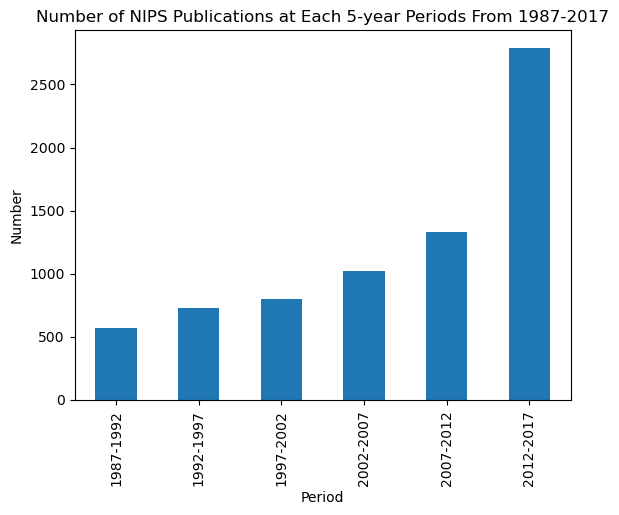

In [5]:
# Group the papers by year
x = ["1987-1992", "1992-1997", "1997-2002", "2002-2007", "2007-2012", "2012-2017"]
papers["period"] = (papers["year"] - 1987)/5
papers["period"] = papers["period"].apply(lambda y: x[min(int(y),5)])
papers.head()
groups = papers.groupby("period")


# Determine the size of each group
counts = groups.size()
print(counts)
# Visualise the counts as a bar plot
import matplotlib.pyplot
%matplotlib inline
ax = counts.plot(kind='bar', title="Number of NIPS Publications at Each 5-year Periods From 1987-2017")
ax.set_xlabel("Period")
ax.set_ylabel("Number")
fig = ax.get_figure()
fig.savefig("numpub.pdf")